# Applied Machine Learning 

### Personal Project



## Table of contents
1. [Understanding the problem](#1)
2. [Data splitting](#2)
3. [EDA](#3)
4. [Feature engineering](#4)
5. [Preprocessing and transformations](#5) 
6. [Baseline model](#6)
7. [Linear models](#7)
8. [Different models](#8)
9. [Feature selection](#9)
10. [Hyperparameter optimization](#10)
11. [Interpretation and feature importances](#11) 
12. [Results on the test set](#12)
13. [Summary of the results](#13)

## Imports

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel




<!-- BEGIN QUESTION -->



<br><br>

#### 1. Understanding the problem
In this data set we are going to help predict the popularity of a listing which is defined as `reviews_per_month`. There are 16 features which include both categorical and numeric features.

Upon first inspection there are some features which could be dropped, this includes host name which would likely be redundant. Other features which could be dropped include id features which may cause over-fitting. More inspections needs to be done on other features which could be dropped.

Input features which are of interest include `number_of_reviews`, this is likely to be highly correlated with `reviews_per_month`. `Price` may also be a feature of interest, generally speaking cheaper listings will attract more guests and have a higher turnover rate which could affect the popularity of the listing. 

*Ultimately, further research will need to be done to look at the importance of the features at hand.*




In [5]:
data = pd.read_csv("data/AB_NYC_2019.csv")
data.head(5)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 2. Data splitting <a name="2"></a>
<hr>


In [6]:
from sklearn.model_selection import train_test_split


# Split the data into train and test sets
train_df, test_df = train_test_split(data, test_size=0.3, random_state=123)

# train_df contain 70% of the data for training
# test_df will contain 30% of the data for testing
train_df.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
36150,28736148,Cozy 1 Bedroom Apt in Hamilton Heights,43431867,Tommy,Manhattan,Washington Heights,40.83256,-73.94440,Entire home/apt,96,4,0,NaN,NaN,1,17
45223,34613254,Amazing One Bedroom at the Time Square Area/72B,48146336,Irina,Manhattan,Hell's Kitchen,40.76134,-73.99299,Entire home/apt,150,30,0,NaN,NaN,20,332
14316,11144496,"New Spacious Master, Williamsburg",48819868,Nick,Brooklyn,Williamsburg,40.71119,-73.95097,Private room,200,1,0,NaN,NaN,1,0


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 3. EDA <a name="3"></a>
1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

## Summary of Initial Observations

#### Visualization Analysis
Our intital EDA found that lower priced listings tend to have a larger volume of reviews per month (`Visualization 1`). This makes sense as inexpensive listings will likely be more popular as they are more accesible to the wider population, leading to more reviews. 

`Visualization 4` found there are some differences in neighbourhood vs Reviews per month. Upon further assessment, we recognize the `neighbourhood group` is essentially a discretization of `longitude and latitude`. Neighbourhood groups is easier to interpret in comparison, this has prompted us to *drop the longitude and latitude columns.* Doing so will help reduce the dimensionality of the data, which will be beneficial for model training as it simplifies the model. In addition, geospatial coordinates may be too highly specific which could lead to over-fitting. Considering this information, we will omit them from our model. 

In terms of growth, `Visualization 7 & 8` indicated there is a clear growth trend which largely accelerated in 2019. The large growth in 2019 may suggest some external factors contributed to this rapid increase but we cannot be sure. `Visualization 9` was created to look at potential seasonal trends but found no clear evidence of linear trends as correlation was quite low. We can seperate last_review into year, month and day to obtain further information.

Ultimately, number of reviews, price, availability 365 and calculated host listings seem to have the strongest correlation based on our heatmap in `Visualization 6` with number of reviews having the strongest correlation. 


#### Summary Statistics
- The describe() function provides key summary statistics for numerical columns, including count, mean, standard deviation, minimum, and maximum. This helps us understand the central tendency and spread of our data.

- train.dtypes tolds us that `last_review` had an object datatype, we can convert this with pd.to_datetime to help with the usability of the data.

- train_info() and train.shape[0] tells us that we have 34226 rows and features like 'name' 'host_name' 'last_review' and 'reviews_per_month' have NaN values which need to be imputed.

- Our correlation matrix tells us number of reviews has the highest correlation with reviews per month at `0.587901`

- There are no duplicate IDs which suggests we don't have duplicate rows.


### Appropriate Metrics
As we will be performing regression, the metrics we will be using will be R-squared, which indicates the proportion of the variance in the dependent variable that is predictable from the independent variables. The reason why we chose this metric is because it provides a quick and interpretable measure of how well our model is capturing the variance in the data.

Another metric we will be using is fit time. There is often a trade-off between model complexity, performance, and computational efficiency. This trade-off is navigated using the purpose of your analysis. For example, in real-time bidding systems, a model must be very fast, often at the expense of some accuracy, while in financial forecasting, accuracy is critical, potentially at the cost of longer computation times. We will aim for a model that is not too computationally expensive due to the nature of this assignment. 

### Summary Statistics

In [7]:
train_df.shape

(34226, 16)

In [8]:
train_df.columns
# Original Columns:
# Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
#        'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
#        'minimum_nights', 'number_of_reviews', 'last_review',
#        'reviews_per_month', 'calculated_host_listings_count',
#        'availability_365'],
#       dtype='object')

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34226 entries, 36150 to 15725
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              34226 non-null  int64  
 1   name                            34216 non-null  object 
 2   host_id                         34226 non-null  int64  
 3   host_name                       34209 non-null  object 
 4   neighbourhood_group             34226 non-null  object 
 5   neighbourhood                   34226 non-null  object 
 6   latitude                        34226 non-null  float64
 7   longitude                       34226 non-null  float64
 8   room_type                       34226 non-null  object 
 9   price                           34226 non-null  int64  
 10  minimum_nights                  34226 non-null  int64  
 11  number_of_reviews               34226 non-null  int64  
 12  last_review                     2

In [10]:
train_df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,3.422600e+04,3.422600e+04,34226.000000,34226.000000,34226.000000,34226.000000,34226.000000,27236.000000,34226.000000,34226.000000
mean,1.893979e+07,6.726273e+07,40.729142,-73.952083,151.528399,7.094957,23.244814,1.369816,7.042453,112.526004
std,1.101332e+07,7.840511e+07,0.054531,0.046201,236.628392,21.548290,44.573323,1.700737,32.590803,131.420031
min,2.539000e+03,2.438000e+03,40.506410,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.394482e+06,7.721897e+06,40.690193,-73.983030,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.954546e+07,3.074526e+07,40.723240,-73.955550,106.000000,3.000000,5.000000,0.710000,1.000000,45.000000
75%,2.915085e+07,1.068375e+08,40.763287,-73.936270,175.000000,5.000000,23.000000,2.000000,2.000000,225.750000
max,3.648561e+07,2.743213e+08,40.912340,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [11]:
summary_statistics_reviews_per_month = train_df['reviews_per_month'].describe()
summary_statistics_reviews_per_month


count    27236.000000
mean         1.369816
std          1.700737
min          0.010000
25%          0.190000
50%          0.710000
75%          2.000000
max         58.500000
Name: reviews_per_month, dtype: float64

In [12]:
numerical_variables = ['price', 'minimum_nights',
                       'number_of_reviews', 'calculated_host_listings_count', 
                       'availability_365', 'reviews_per_month']


correlation_matrix = train_df[numerical_variables].corr()

# Correlation Matrix of Numerical Features
correlation_matrix


,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,reviews_per_month
price,1.000000,0.031717,-0.047802,0.060032,0.085142,-0.033062
minimum_nights,0.031717,1.000000,-0.074642,0.123040,0.139341,-0.111594
number_of_reviews,-0.047802,-0.074642,1.000000,-0.071658,0.172544,0.548976
calculated_host_listings_count,0.060032,0.123040,-0.071658,1.000000,0.226027,-0.010565
availability_365,0.085142,0.139341,0.172544,0.226027,1.000000,0.187546
reviews_per_month,-0.033062,-0.111594,0.548976,-0.010565,0.187546,1.000000


In [13]:
for col in train_df.columns:
    print(f'Name: {col} | Number of Duplicates: {train_df[col].duplicated().sum()}')

Name: id | Number of Duplicates: 0
Name: name | Number of Duplicates: 563
Name: host_id | Number of Duplicates: 6707
Name: host_name | Number of Duplicates: 25024
Name: neighbourhood_group | Number of Duplicates: 34221
Name: neighbourhood | Number of Duplicates: 34008
Name: latitude | Number of Duplicates: 17772
Name: longitude | Number of Duplicates: 21275
Name: room_type | Number of Duplicates: 34223
Name: price | Number of Duplicates: 33614
Name: minimum_nights | Number of Duplicates: 34127
Name: number_of_reviews | Number of Duplicates: 33856
Name: last_review | Number of Duplicates: 32549
Name: reviews_per_month | Number of Duplicates: 33338
Name: calculated_host_listings_count | Number of Duplicates: 34179
Name: availability_365 | Number of Duplicates: 33860


#### Visualization 1: Price v. Number of Reviews Coloured by Room Type
- A scatterplot investigating price plotted against number of reviews coloured by one of three 
room types (Entire Home, Private Room, Shared Room)

- We find that data with lower prices have more reviews, indicating that those looking for airbnbs
prefer to find lower priced listings. 

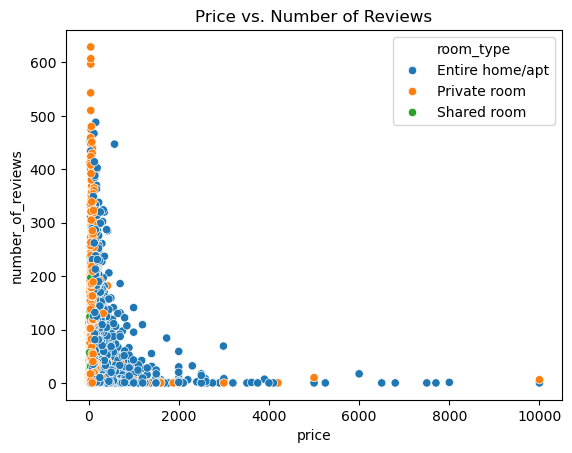

In [14]:

ax =sns.scatterplot(x='price',
                y='number_of_reviews',
                hue='room_type',
                data=train_df)
ax.set_title('Price vs. Number of Reviews')
plt.show()


#### Visualization 2: Price v. Reviews Per Month Coloured by Room Type

- A scatterplot investigating price plotted against reviews per month coloured by one of three room types (Entire Home, Private Room, Shared Room)

- We find that data with lower prices have more reviews per month,
again, strengthing our hypothesis that lower prices get more reviews and are more popular

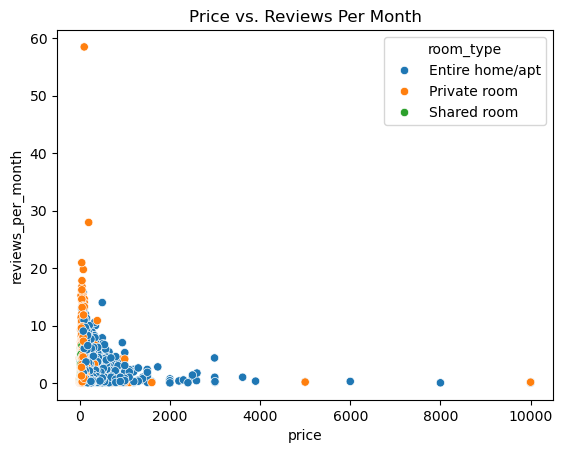

In [15]:
ax =sns.scatterplot(x='price',
                y='reviews_per_month',
                hue='room_type',
                data=train_df)
ax.set_title('Price vs. Reviews Per Month')
plt.show()

#### Visuazation 3. Number of Reviews vs Reviews Per Month

- A scatter plot of number of reviews against reviews per month

- There is some evidence of a correlation between number of reviews per month and number of reviews. Listings with high number of reviews but low reviews per month may be older listings.

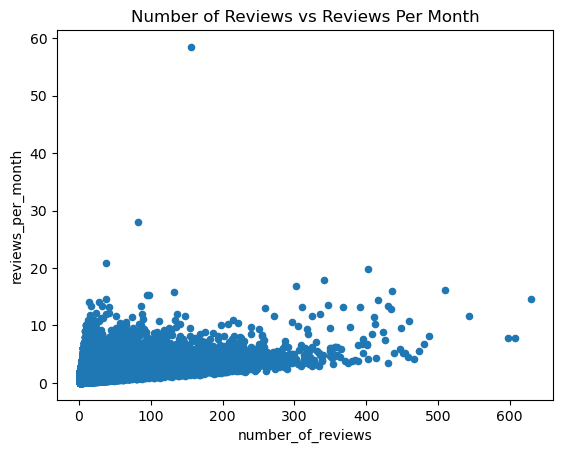

In [16]:
train_df.plot(kind='scatter',
        x='number_of_reviews',
        y='reviews_per_month',
        title='Number of Reviews vs Reviews Per Month')
plt.show()

#### Visuazation 4. Boxplot of Neighbourhood group vs Reviews Per Month With Outliers Removed

- A boxplot with room type and reviews per month with outliers removed to help with the readability of the plots, from this graph we can infer that most areas median are similar with queens generally getting more reviews than other neighbourhoods.

- These boxplots suggest there are some difference in reviews per months amongst different neighbourhood groups. 

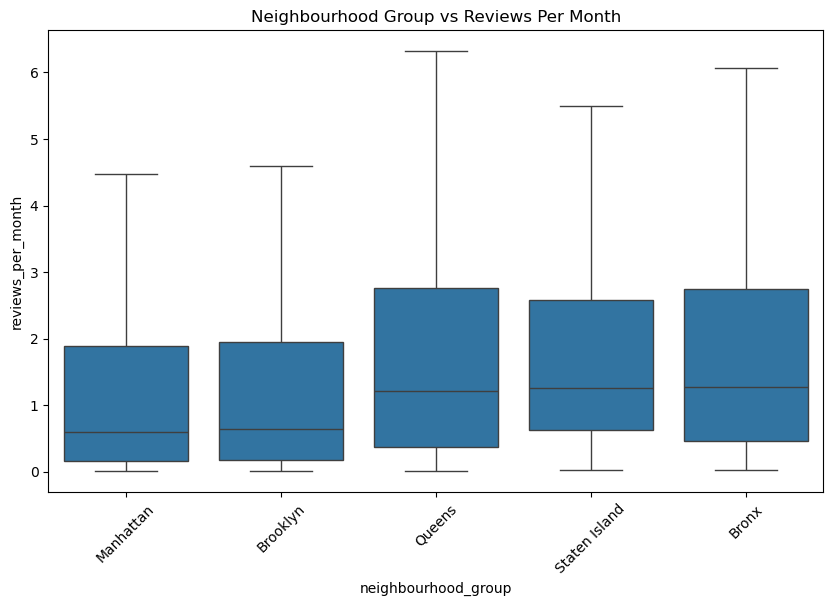

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='neighbourhood_group', y='reviews_per_month', data=train_df, showfliers=False)
plt.title('Neighbourhood Group vs Reviews Per Month')
plt.xticks(rotation=45)
plt.show()

#### Visuazation 5. Boxplot of Room Types vs Reviews Per Month With Outliers Removed

- This is a Boxplot of Room Types vs Reviews Per Month With Outliers Removed for readability.

- From this graph we can infer that room type may not have a large effect on our target variable.

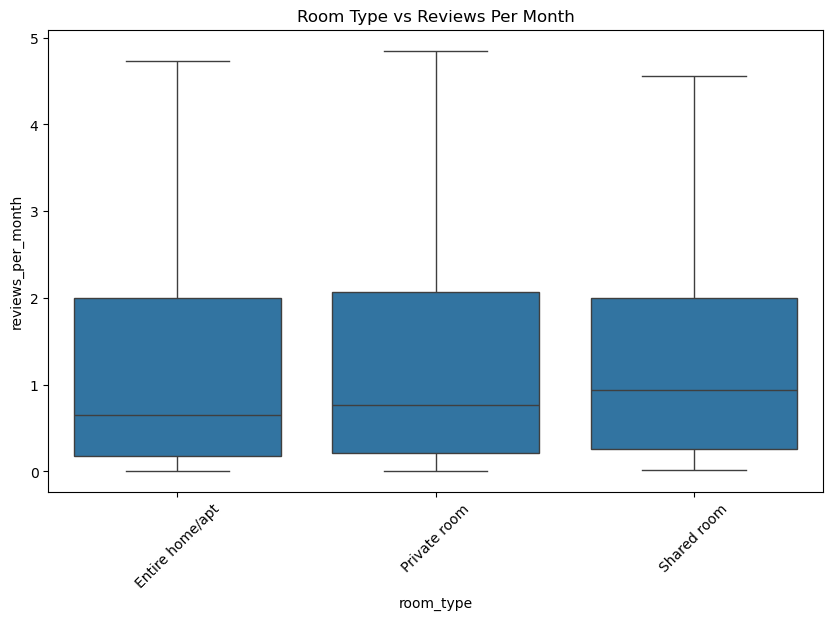

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='reviews_per_month', data=train_df, showfliers=False)
plt.title('Room Type vs Reviews Per Month')
plt.xticks(rotation=45)
plt.show()

#### Visuazation 6. Heatmap of Correlation matrix between all numerical Variables

- A heatmap of the correlation between out different numerical variables

- Reviews per month and number of reviews seem to have the strongest correlation as expected.

- Reviews per month and availably 365 also have some correlation as rooms available 365 days of the year will likely have more reviews per month


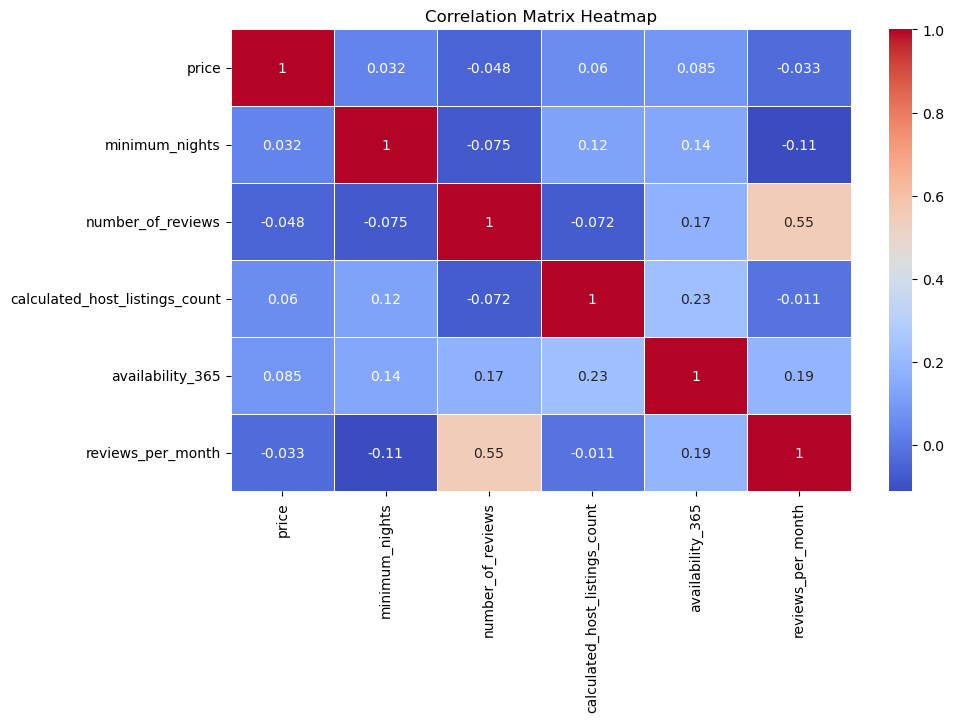

In [19]:
numerical_variables = ['price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365', 'reviews_per_month']


subset_data = train_df[numerical_variables]


correlation_matrix = subset_data.corr()

# heatmap of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


#### Visulisation 7. Reviews Per Month by year with outliers removed

- A box plot of reviews per month by year with outliers removed

- We see clear acclerated growth overtime, especially in the year 2019

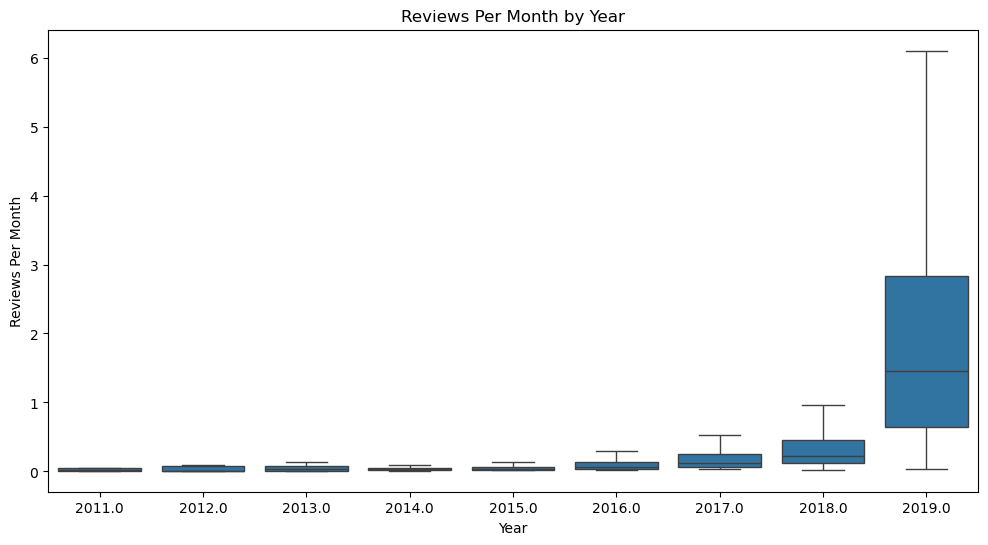

In [20]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=pd.to_datetime(train_df['last_review']).dt.year, y=train_df['reviews_per_month'], showfliers = False)
plt.title('Reviews Per Month by Year')
plt.xlabel('Year')
plt.ylabel('Reviews Per Month')
plt.show()

#### Visulisation 8. Reviews Per Month vs one-year lagged reviews per month

- We lagged reviews per month by 12 to see if the reviews of a previous month could predict the reviews of the next year in order to account for seasonal trends.

- There seems to be no correlation between the lagged reviews per month and reviews in current month. This could indicate lack of seasonal trends (or at least no linear relationship) but you would need to look into the data further to discover more.

- In order to extrapolate more information from last_review, we would separate it into year, month, and day and use them as three separate numerical features. 

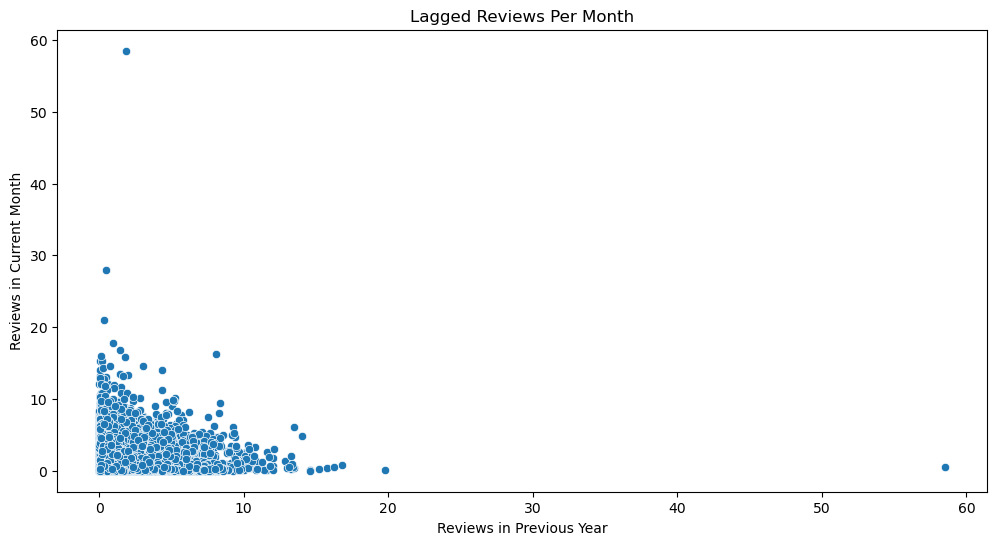

Correlation between Lagged Reviews and Current Reviews: -0.004679746851496089


In [21]:
train_df['lagged_reviews'] = train_df['reviews_per_month'].shift(12)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='lagged_reviews', y='reviews_per_month', data=train_df)
plt.title('Lagged Reviews Per Month')
plt.xlabel('Reviews in Previous Year')
plt.ylabel('Reviews in Current Month')
plt.show()
correlation = train_df['lagged_reviews'].corr(train_df['reviews_per_month'])
print("Correlation between Lagged Reviews and Current Reviews:", correlation)

#### Visulisation 9. Reviews Per Month vs lagged reviews per month 

- We lagged reviews per month by 1 to see if the reviews of a previous month could predict the reviews of the next month

- There seems to be no correlation between the lagged reviews per month and reviews in current month. 

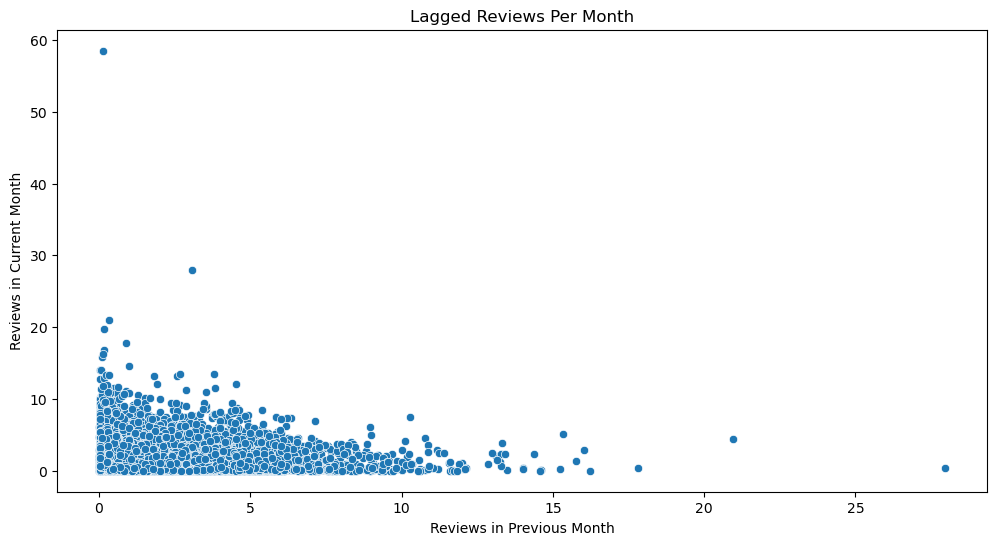

Correlation between Lagged Reviews and Current Reviews: -0.004180893595007159


In [22]:
train_df['lagged_reviews'] = train_df['reviews_per_month'].shift(1)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='lagged_reviews', y='reviews_per_month', data=train_df)
plt.title('Lagged Reviews Per Month')
plt.xlabel('Reviews in Previous Month')
plt.ylabel('Reviews in Current Month')
plt.show()
correlation = train_df['lagged_reviews'].corr(train_df['reviews_per_month'])
print("Correlation between Lagged Reviews and Current Reviews:", correlation)

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 4. Feature engineering <a name="4"></a>


In [23]:

X = data.drop('reviews_per_month', axis=1)  
y = data['reviews_per_month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)



#### Seperating last_review into Separate Numerical Features

- Note: We converted train_df['last_review'] to pd datetime format earlier on.

In [24]:
# Convert the 'last_review' column to a datetime data type
X_train['last_review'] = pd.to_datetime(X_train['last_review'])
X_test['last_review'] = pd.to_datetime(X_test['last_review'])

# Extract year, month, and day into new columns
X_train['review_year'] = X_train['last_review'].dt.year
X_train['review_month'] = X_train['last_review'].dt.month
X_train['review_day'] = X_train['last_review'].dt.day

X_test['review_year'] = X_test['last_review'].dt.year
X_test['review_month'] = X_test['last_review'].dt.month
X_test['review_day'] = X_test['last_review'].dt.day


### Feature discretization

#### Price Category

- Through discretizting price into different categories it can help with out decision tree model.

In [25]:
X_train['price_category'] = pd.cut(
    X_train['price'],
    bins=[-float('inf'), 50, 100, 150, 200, 250, 300, 350, float('inf')],
    labels=['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-350', '350+'],
    include_lowest=True
)

X_test['price_category'] = pd.cut(
    X_test['price'],
    bins=[-float('inf'), 50, 100, 150, 200, 250, 300, 350, float('inf')],
    labels=['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-350', '350+'],
    include_lowest=True
)

X_train['price_category'].info()

<class 'pandas.core.series.Series'>
Index: 34226 entries, 36150 to 15725
Series name: price_category
Non-Null Count  Dtype   
--------------  -----   
34226 non-null  category
dtypes: category(1)
memory usage: 301.2 KB


#### Minimum Nights Category

Minimum nights are mostly concentrated amongst lower ranges, thus, we decided that creating bins up to 30 in increments of 5 would provide more insight as opposed to treating the data like a continuous variable. 

In [26]:
X_train['minimum_nights_category'] = pd.cut(
    X_train['minimum_nights'],
    bins=[0, 5, 10, 15, 20, 25, 30, float('inf')],
    labels=['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30+']
)

X_test['minimum_nights_category'] = pd.cut(
    X_test['minimum_nights'],
    bins=[0, 5, 10, 15, 20, 25, 30, float('inf')],
    labels=['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30+']
)


X_test['minimum_nights_category'].info()

<class 'pandas.core.series.Series'>
Index: 14669 entries, 29122 to 6162
Series name: minimum_nights_category
Non-Null Count  Dtype   
--------------  -----   
14669 non-null  category
dtypes: category(1)
memory usage: 129.3 KB


#### Superhost (Calculated host listings count > threshold)
A host with many properties might be more experienced, we can create a binary indicator using a threshold, for this sceanrio I will use a threshold of 5.



In [27]:
threshold = 5
X_train['is_superhost'] = X_train['calculated_host_listings_count'] > threshold

X_test['is_superhost'] = X_test['calculated_host_listings_count'] > threshold


X_train.columns


Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'calculated_host_listings_count', 'availability_365', 'review_year',
       'review_month', 'review_day', 'price_category',
       'minimum_nights_category', 'is_superhost'],
      dtype='object')

#### Null Values in y_train and y_test

- As we can see there are reviews per month put null values any time `review_per_month` was 0, thus we can impute zero into null values in this column

In [28]:
np.isnan(y_train).sum()
# Filling in Reviews_per_month null values
y_train = np.where(np.isnan(y_train), 0, y_train)
y_test = np.where(np.isnan(y_train), 0, y_train)
np.isnan(y_train).sum()

0

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 5. Preprocessing and transformations


#### List of our Features

In [29]:
numerical_features = ['price', 
                   'minimum_nights', 
                   'calculated_host_listings_count',
                   'availability_365',
                  'review_year',
                    'review_month', 
                      'review_day',]

categorical_features = ['neighbourhood_group', 
                     'neighbourhood',
                     'room_type']

ordinal_features = ['price_category', 
                 'minimum_nights_category']

binary_features = ['is_superhost']

text_data = ['name'] # took too long for count vectorizer

drop_features = ['number_of_reviews', 
                 'host_id', 'id',
                 'last_review',
                 'host_name','latitude', 'longitude', 'name']

target = ['reviews_per_month']


In [30]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder


# Transformer for binary features: convert boolean to numeric then apply imputation
def bool_to_numeric(x):
    # Convert boolean to int (True to 1, False to 0)
    return x.astype(int)

binary_transformer = Pipeline(steps=[
    ('convert_to_numeric', FunctionTransformer(bool_to_numeric)),
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Now imputer can handle it because it's numeric
    # No need to encode since it's already in binary (0/1) format
])


In [31]:
price_category_ordering = ['0-50',
                           '50-100', 
                           '100-150', 
                           '150-200',
                           '200-250', 
                           '250-300', 
                           '300-350', 
                           '350+']
 
minimum_nights_category_ordering = ['0-5',
                                    '5-10', 
                                    '10-15', 
                                    '15-20',
                                    '20-25', 
                                    '25-30', 
                                    '30+']

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), 
    ('ordinal', OrdinalEncoder(categories=[price_category_ordering, 
                                           minimum_nights_category_ordering]))
])



# Create the column transformer
ct = make_column_transformer(
    ('drop', drop_features), 
    (StandardScaler(), numerical_features),  
    (OneHotEncoder(handle_unknown="ignore"), categorical_features),  
    (ordinal_transformer, ordinal_features),  
    (binary_transformer, binary_features),
    remainder='passthrough'  
)


In [32]:
from sklearn.impute import SimpleImputer

freq_imputer = SimpleImputer(strategy='most_frequent')

X_train[['review_month', 'review_day']] = freq_imputer.fit_transform(X_train[['review_month', 'review_day']])
X_test[['review_month', 'review_day']] = freq_imputer.fit_transform(X_test[['review_month', 'review_day']])

In [33]:
def random_impute_year(df, column_name):
    # Randomly choose a year based on the distribution of the existing years
    probs = df[column_name].value_counts(normalize=True)
    missing = df[column_name].isna()
    imputed_years = np.random.choice(probs.index, size=missing.sum(), p=probs.values)
    df.loc[missing, column_name] = imputed_years
    return df

X_train = random_impute_year(X_train, 'review_year')
X_test = random_impute_year(X_test, 'review_year')

<!-- END QUESTION -->

<br><br>



## 6. Baseline model


In [34]:
from sklearn.dummy import DummyRegressor #import regressor

reg = DummyRegressor() # Create a classifier object



In [35]:
from sklearn.pipeline import Pipeline, make_pipeline

pipe = make_pipeline(ct, reg)
pipe.fit(X_train,y_train)
pipe.predict(X_train)
f'Test Score is: {pipe.score(X_train,y_train)}'

'Test Score is: 0.0'

<!-- END QUESTION -->





## 7. Linear models


#### Data Summary

Ridge() regression model trained and scored quickly, but the test and train scores suggest that the model is not very accurate or that the score metric is quite low.
And at different strength of regularization (Alpha) we see that the test score is at the highest at alpha = 10 but is still low. Our results are stored in `results_df` with our best score being a test score of 0.246 with a train score of 0.254. 

Since this is a linear model and the data is showing a low score, the model and the features we are choosing might not be a linearly fit data. This makes sense as we introduced new categorical variables and ordinal variables which should work better with decision trees. 

In [36]:

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)


from sklearn.linear_model import Ridge 
from sklearn.model_selection import cross_val_score, cross_validate
pipe = make_pipeline(ct, Ridge())
scores =  mean_std_cross_val_scores(pipe, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

/var/folders/fy/1_r80v9j3s39nw5nw46_dw800000gq/T/ipykernel_7291/924811516.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


,0
fit_time,0.406 (+/- 0.105)
score_time,0.022 (+/- 0.006)
test_score,0.245 (+/- 0.020)
train_score,0.257 (+/- 0.006)


In [37]:
scores_dict = {
    "alpha": 10.0 ** np.arange(-3, 6, 1)
    # "mean_train_scores": list(),
    # "mean_cv_scores": list(),
}
scores = {}
for alpha in scores_dict["alpha"]:
    pipe_ridge = make_pipeline(ct, Ridge(alpha=alpha))
    scores[f"Ridge alpha={alpha}"] = mean_std_cross_val_scores(pipe_ridge, X_train, y_train, return_train_score=True)
    # scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    # scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores).T

/var/folders/fy/1_r80v9j3s39nw5nw46_dw800000gq/T/ipykernel_7291/924811516.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
/var/folders/fy/1_r80v9j3s39nw5nw46_dw800000gq/T/ipykernel_7291/924811516.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
/var/folders/fy/1_r80v9j3s39nw5nw46_dw800000gq/T/ipykernel_7291/924811516.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels 

In [38]:
results_df

,fit_time,score_time,test_score,train_score
Ridge alpha=0.001,0.366 (+/- 0.039),0.020 (+/- 0.004),0.244 (+/- 0.020),0.257 (+/- 0.006)
Ridge alpha=0.01,0.335 (+/- 0.014),0.017 (+/- 0.002),0.244 (+/- 0.020),0.257 (+/- 0.006)
Ridge alpha=0.1,0.350 (+/- 0.049),0.017 (+/- 0.001),0.244 (+/- 0.020),0.257 (+/- 0.006)
Ridge alpha=1.0,0.260 (+/- 0.018),0.017 (+/- 0.002),0.245 (+/- 0.020),0.257 (+/- 0.006)
Ridge alpha=10.0,0.178 (+/- 0.012),0.017 (+/- 0.001),0.247 (+/- 0.021),0.255 (+/- 0.006)
Ridge alpha=100.0,0.107 (+/- 0.002),0.016 (+/- 0.001),0.242 (+/- 0.019),0.246 (+/- 0.006)
Ridge alpha=1000.0,0.112 (+/- 0.021),0.020 (+/- 0.002),0.229 (+/- 0.016),0.229 (+/- 0.005)
Ridge alpha=10000.0,0.124 (+/- 0.029),0.026 (+/- 0.004),0.208 (+/- 0.014),0.208 (+/- 0.004)
Ridge alpha=100000.0,0.174 (+/- 0.125),0.028 (+/- 0.005),0.100 (+/- 0.006),0.100 (+/- 0.002)


<!-- END QUESTION -->

<br><br>



## 8. Different models <a name="8"></a>


### Summary


#### Gradient Boost Regressor
Our Gradient boost regressor model was our strongest model with a test score of 0.547 and a train score of 0.555. The closeness of the train and test scores suggest the model is not overfitting and is generalizing well for new data. However, both scores are moderate, this may indicate the model is under-fitting the data as it might be too simple to capture the underlying structure of the data. We could improve the model through optimizing the parameters of n_estimator, learning rate and max depth. 



## Gradient Boost Regressor

In [41]:
y_imputed_rf = np.ravel(y_train)

In [42]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the Gradient Boosting Regressor
gbm = GradientBoostingRegressor(n_estimators=40, learning_rate=0.1, max_depth=3, random_state=42)

#pipeline with column-transformer and model
pipe_GBR = make_pipeline(
    ct,
    gbm,
)

# Evaluate the model
scores = mean_std_cross_val_scores(
    pipe_GBR, X_train, y_imputed_rf, return_train_score=True
)

pd.DataFrame(scores).T

/var/folders/fy/1_r80v9j3s39nw5nw46_dw800000gq/T/ipykernel_7291/924811516.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


,fit_time,score_time,test_score,train_score
0,1.022 (+/- 0.044),0.018 (+/- 0.001),0.547 (+/- 0.035),0.554 (+/- 0.009)


<!-- END QUESTION -->

<br><br>



## 9. Feature selection 


#### Feature Selection Results

Our feature selection managed to reduce the amount of features whilst keeping test score the same at 0.547, train score the same at 0.555 but reducing fit time to 0.827. This shows our feature selection benefitted our model.

In [43]:
X_train_imputed = ct.fit_transform(X_train)
X_test_imputed = ct.transform(X_test)

In [44]:
y_test.shape

(34226,)

In [45]:

gbm.fit(X_train_imputed, y_train)
selector = SelectFromModel(gbm, prefit=True, threshold='0.01*mean')
X_train_new = selector.transform(X_train_imputed)
X_test_new = selector.transform(X_test_imputed)
print(X_train.shape, X_train_new.shape)


reduced_model = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=40, random_state=42)
reduced_model.fit(X_train_new, y_train)


scores = mean_std_cross_val_scores(
    reduced_model, X_train_new, y_imputed_rf, return_train_score=True
)

pd.DataFrame(scores).T

(34226, 21) (34226, 17)


/var/folders/fy/1_r80v9j3s39nw5nw46_dw800000gq/T/ipykernel_7291/924811516.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


,fit_time,score_time,test_score,train_score
0,0.764 (+/- 0.050),0.004 (+/- 0.001),0.547 (+/- 0.035),0.554 (+/- 0.009)


In [56]:
features = numerical_features 

['price',
 'minimum_nights',
 'calculated_host_listings_count',
 'availability_365',
 'review_year',
 'review_month',
 'review_day',
 'neighbourhood_group',
 'neighbourhood',
 'room_type',
 'price_category',
 'minimum_nights_category',
 'is_superhost']

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 10. Hyperparameter optimization <a name="10"></a>


## GBM Regression

Note, when we randomly ran it we got a better value (0.547 test score and 0.554 train score). This could be due to the fact that gridsearch optimizes hyperparameters within the specified grid, and it might be missing better-performing hyperparameters that lie outside of the grid, our paramgrid is stricted by the range as the runtime gets too long if we increase in the ranges of values for each parameter. 

In [46]:
from sklearn.model_selection import GridSearchCV

# Define a parameter grid to search
param_grid = {
    # 'selectkbest__k': [5,10,15],
    'gradientboostingregressor__n_estimators': [10, 40, 100],
    'gradientboostingregressor__learning_rate': [0.05,0.1],
    'gradientboostingregressor__max_depth': [3,4],
}


# Initialize the GridSearchCV object
grid_search = GridSearchCV(pipe_GBR, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best estimator and its parameters
best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_

# Get the cross-validated scores for the best model
best_cv_scores = grid_search.cv_results_

# Convert the scores into a DataFrame
scores_df = pd.DataFrame(best_cv_scores)

# Display the best parameters
print("Best parameters found: ", best_params)



scores_df



Best parameters found:  {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 4, 'gradientboostingregressor__n_estimators': 100}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingregressor__learning_rate,param_gradientboostingregressor__max_depth,param_gradientboostingregressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.320391,0.016762,0.014598,0.000692,0.05,3,10,{'gradientboostingregressor__learning_rate': 0...,0.281656,0.277440,0.248126,0.299648,0.287497,0.278873,0.017095,12
1,1.054211,0.017770,0.016815,0.000858,0.05,3,40,{'gradientboostingregressor__learning_rate': 0...,0.502189,0.493550,0.434570,0.523266,0.501356,0.490986,0.029881,8
2,2.441416,0.031732,0.023891,0.000989,0.05,3,100,{'gradientboostingregressor__learning_rate': 0...,0.569028,0.564422,0.498523,0.585918,0.561934,0.555965,0.029915,5
3,0.450697,0.027424,0.036957,0.036874,0.05,4,10,{'gradientboostingregressor__learning_rate': 0...,0.332582,0.328614,0.284734,0.338875,0.330140,0.322989,0.019446,11
4,1.560561,0.037877,0.018004,0.000543,0.05,4,40,{'gradientboostingregressor__learning_rate': 0...,0.546293,0.543768,0.472081,0.563394,0.541462,0.533400,0.031617,7
5,3.525303,0.071390,0.026884,0.000930,0.05,4,100,{'gradientboostingregressor__learning_rate': 0...,0.589397,0.593309,0.519303,0.599973,0.576336,0.575664,0.029216,2
6,0.297005,0.005433,0.014181,0.000557,0.1,3,10,{'gradientboostingregressor__learning_rate': 0...,0.409144,0.402226,0.354662,0.425211,0.407357,0.399720,0.023805,10
7,1.000134,0.002500,0.016299,0.000442,0.1,3,40,{'gradientboostingregressor__learning_rate': 0...,0.559825,0.557125,0.486998,0.579159,0.553483,0.547318,0.031442,6
8,2.344443,0.045384,0.024383,0.002987,0.1,3,100,{'gradientboostingregressor__learning_rate': 0...,0.584161,0.593458,0.516391,0.592500,0.572397,0.571782,0.028708,3
9,0.449064,0.023178,0.016405,0.002438,0.1,4,10,{'gradientboostingregressor__learning_rate': 0...,0.466278,0.460716,0.402230,0.481363,0.465803,0.455278,0.027407,9


## Ridge Linear Regression 

The optimal regularization strength for the Ridge regression model is alpha = 10.0, which offers the best trade-off between complexity and performance on the training data.

Best parameter:  {'ridge__alpha': 10.0}


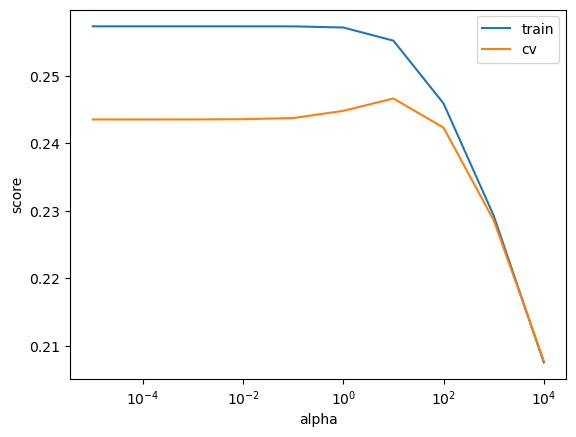

In [47]:
param_grid = {"ridge__alpha": 10.0 ** np.arange(-5, 5, 1)}

pipe_ridge = make_pipeline(ct, Ridge())

search = GridSearchCV(pipe_ridge, param_grid, return_train_score=True, n_jobs=-1)
search.fit(X_train, y_train)
train_scores = search.cv_results_["mean_train_score"]
cv_scores = search.cv_results_["mean_test_score"]
plt.semilogx(param_grid["ridge__alpha"], train_scores.tolist(), label="train")
plt.semilogx(param_grid["ridge__alpha"], cv_scores.tolist(), label="cv")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("score");
best_parameter = search.best_params_
print("Best parameter: ", best_parameter)
best_alpha_ridge = best_parameter

<!-- END QUESTION -->

<br><br>


## 11. Interpretation and feature importances 

Feature importance of numerical variables with shap

In [77]:
import shap
import xgboost as xg

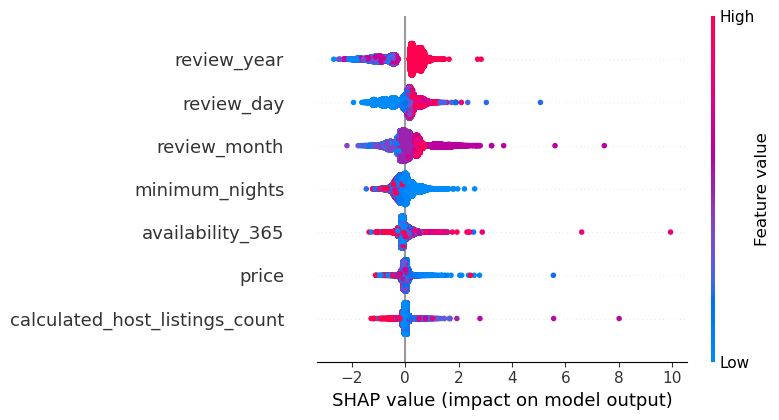

In [79]:
num = X_train[numerical_features]
num_test = X_test[numerical_features]

xg_model = xg.XGBRegressor()
xg_model.fit(num, y_train)
explainer = shap.Explainer(xg_model)
explainer
shap_values = explainer(np.vstack((num, num_test)))
shap.summary_plot(shap_values, np.vstack((num, num_test)), feature_names=numerical_features)

plt.show()


<!-- END QUESTION -->

<br><br>


## 12. Results on the test set 
 

1. Our best performing model had a test score 0f 0.547 and a train score of 0.555. It also had a fit time of 0.856.

2. The test scores agree with the validation scores from before, this indicates that our model generlizes well to new unseen data. Regarding the extent of trust in the results, it depends on various factors, including the size and quality of the dataset, the robustness of the model, and the thoroughness of the evaluation process. Trust in the results can be increased by using cross-validation, ensuring data preprocessing is appropriate, and validating the model's assumptions. We thing we had some issues with optimization bias as our hyperparameters were fine-tuned on our validation performance (which we eventually reduced for run times sake). To mitigate optimization bias, we made sure to have a separate test set that the model has never seen during the development or tuning process.

3. Our shap imports and eli5 imports didnt work. 

In [ ]:
reduced_model = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=40, random_state=42)
reduced_model.fit(X_train_new, y_train)


scores = mean_std_cross_val_scores(
    reduced_model, X_train_new, y_imputed_rf, return_train_score=True
)

pd.DataFrame(scores).T

/var/folders/fy/1_r80v9j3s39nw5nw46_dw800000gq/T/ipykernel_54585/924811516.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


,fit_time,score_time,test_score,train_score
0,0.861 (+/- 0.030),0.004 (+/- 0.000),0.547 (+/- 0.033),0.555 (+/- 0.009)


<!-- END QUESTION -->

<br><br>



## 13. Summary of results

### Concluding Remarks 
The summarized results show that among the considered models, the Gradient Boosting Regressor has the highest cross-validation score with parameters tuned for optimal performance. The Random Forest Regressor also performed well, but with a large discrepancy between training and test scores, suggesting overfitting.

The Ridge Regression, with its alpha set to 10.0, showed the least discrepancy between train and test scores but also the lowest overall test score, indicating it might be underfitting or that the dataset has a non-linear pattern that linear models cannot capture effectively.

The KNN Regressor has a relatively low test score compared to the ensemble methods, and a considerable difference between train and test scores, indicating overfitting. Moreover, its score time is substantially higher due to the lazy learning nature of KNN, where the algorithm uses the entire dataset to make predictions.


#### Future Improvements/Developments

Data Preprocessing: More sophisticated data preprocessing could be explored, such as feature engineering, selection, or extraction methods (e.g., PCA).

Hyperparameter Tuning: A more extensive grid search or randomized search for hyperparameters could yield better-performing models, albeit at the cost of computation time.

Ensemble Techniques: Combining the predictions of several models through techniques like stacking or blending might improve overall performance.

Feature Importance: Analyzing feature importance and potentially removing non-informative features could simplify the models and potentially increase interpretability without a significant loss in performance.

Advanced Algorithms: Trying out more advanced algorithms like XGBoost, LightGBM, or CatBoost, which are more sophisticated gradient boosting algorithms and often perform better.

Model Interpretability: Tools such as SHAP or LIME could be used to gain better insight into how model predictions are being made, which could in turn inform additional feature engineering or model selection choices.

Cross-Validation Strategy: Different cross-validation strategies, like stratified or time-series splits, could provide insights into model stability across different data segments.

Dealing with Imbalanced Data: If the dataset is imbalanced, techniques like SMOTE for oversampling or different evaluation metrics that focus on the minority class could be useful.

Deep Learning: For large datasets with complex patterns, deep learning models could be considered, although they require substantial computational resources and may be less interpretable.

In [ ]:
# putting our data into a dataframe
data = {
    "Model": [
        "Ridge Regression",
        "Random Forest Regressor",
        "Gradient Boosting Regressor",
        "KNN Regressor"
    ],
    "Optimal Parameters": [
        "alpha = 10.0",
        "n_estimators = 20",
        "learning_rate = 0.1, max_depth = 4, n_estimators = 100",
        "Not Specified"
    ],
    "Fit Time (s)": [
        "0.238 (+/- 0.020)",
        "20.966 (+/- 0.295)",
        "1.037 (+/- 0.043)",
        "0.061 (+/- 0.009)"
    ],
    "Score Time (s)": [
        "0.014 (+/- 0.001)",
        "0.064 (+/- 0.012)",
        "0.017 (+/- 0.001)",
        "3.992 (+/- 0.052)"
    ],"Test Score": [
        "0.244 (+/- 0.021)",
        "0.546 (+/- 0.026)",
        "0.547 (+/- 0.034)",
        "0.295 (+/- 0.041)"
    ],
    "Train Score": [
        "0.256 (+/- 0.006)",
        "0.930 (+/- 0.002)",
        "0.554 (+/- 0.009)",
        "0.651 (+/- 0.010)"
    ]
}

results_df = pd.DataFrame(data)
print(results_df)

                         Model  \
0             Ridge Regression   
1      Random Forest Regressor   
2  Gradient Boosting Regressor   
3                KNN Regressor   

                                  Optimal Parameters        Fit Time (s)  \
0                                       alpha = 10.0   0.238 (+/- 0.020)   
1                                  n_estimators = 20  20.966 (+/- 0.295)   
2  learning_rate = 0.1, max_depth = 4, n_estimato...   1.037 (+/- 0.043)   
3                                      Not Specified   0.061 (+/- 0.009)   

      Score Time (s)         Test Score        Train Score  
0  0.014 (+/- 0.001)  0.244 (+/- 0.021)  0.256 (+/- 0.006)  
1  0.064 (+/- 0.012)  0.546 (+/- 0.026)  0.930 (+/- 0.002)  
2  0.017 (+/- 0.001)  0.547 (+/- 0.034)  0.554 (+/- 0.009)  
3  3.992 (+/- 0.052)  0.295 (+/- 0.041)  0.651 (+/- 0.010)  


In [ ]:
...

<!-- END QUESTION -->

<br><br>

<br><br>

![](img/eva-well-done.png)